In [3]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib

## Model setup

In [4]:
def train_and_evaluate_models(X, y, target_name):
    print(f"\n===== Training models for: {target_name} =====")

    # 切分資料集
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        "SVR": SVR(),
        "RandomForest": RandomForestRegressor(random_state=42),
        "DecisionTree": DecisionTreeRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42)
    }

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        results.append({
            "model": name,
            "target": target_name,
            "MSE": mse
        })
        print(f"{name} - MSE: {mse:.4f}")

    return results

## Load data

In [5]:
from scipy import sparse
import pandas as pd

df = pd.read_csv("../../output_dataset/csr_text_processed_v0_preprocessed.csv")

all_results = []

for k in [1000, 2000, 3000, 5000]:
    for target in ["count", "citation"]:
        tfidf_path = f"../../output_dataset/tfidf_top{k}_{target}_k{k}.npz"
        X = sparse.load_npz(tfidf_path)
        y = df["patent_count"].values if target == "count" else df["citation_count"].values

        results = train_and_evaluate_models(X, y, target_name=f"{target}_k{k}")
        all_results.extend(results)



===== Training models for: count_k1000 =====
SVR - MSE: 645.7127
RandomForest - MSE: 224.8754
DecisionTree - MSE: 534.6711
XGBoost - MSE: 299.4062

===== Training models for: citation_k1000 =====
SVR - MSE: 28574.1801
RandomForest - MSE: 9462.6469
DecisionTree - MSE: 21323.0268
XGBoost - MSE: 8975.4186

===== Training models for: count_k2000 =====
SVR - MSE: 631.7726
RandomForest - MSE: 124.2705
DecisionTree - MSE: 369.1644
XGBoost - MSE: 194.1003

===== Training models for: citation_k2000 =====
SVR - MSE: 28439.0728
RandomForest - MSE: 16272.5786
DecisionTree - MSE: 12095.6342
XGBoost - MSE: 12960.1677

===== Training models for: count_k3000 =====
SVR - MSE: 628.3261
RandomForest - MSE: 108.0992
DecisionTree - MSE: 589.0101
XGBoost - MSE: 181.1947

===== Training models for: citation_k3000 =====
SVR - MSE: 28540.3770
RandomForest - MSE: 11125.4736
DecisionTree - MSE: 37190.0268
XGBoost - MSE: 9362.0833

===== Training models for: count_k5000 =====
SVR - MSE: 635.3914
RandomForest - M

In [6]:
# 結果整理與儲存
results_df = pd.DataFrame(all_results)
results_df.to_csv("../output/baseline_model_eval_results.csv", index=False)
print("✅ 所有模型訓練與評估完成，結果已儲存。")


✅ 所有模型訓練與評估完成，結果已儲存。


# Draw

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

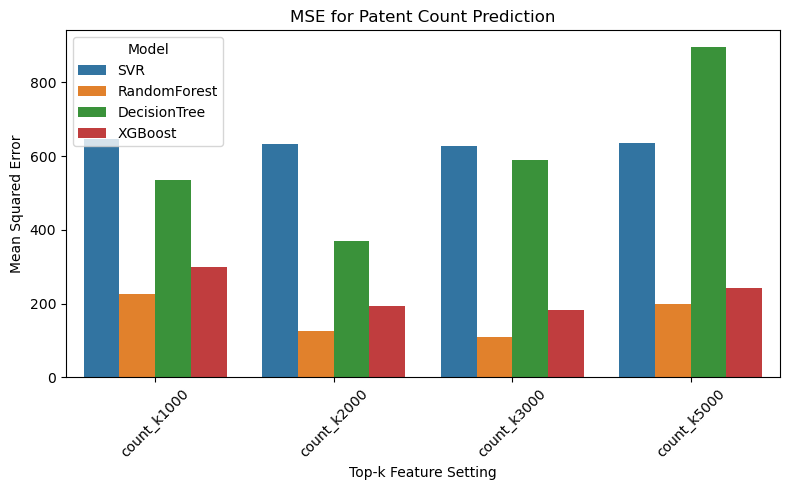

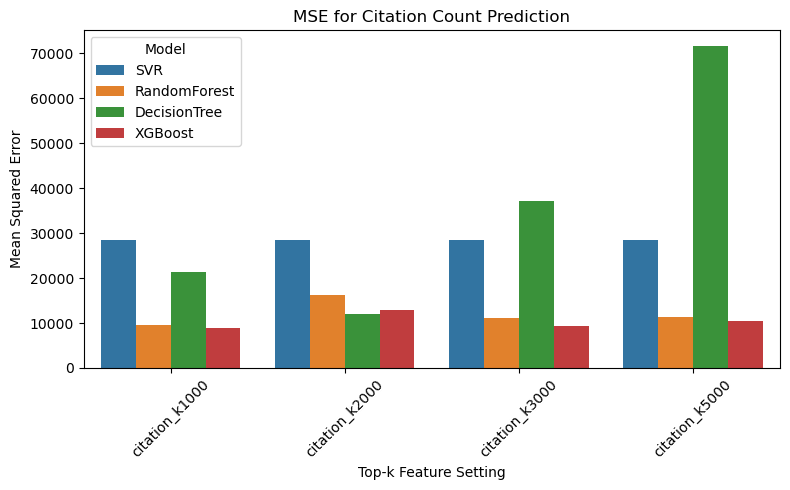

In [11]:
# Count
plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_df[results_df["target"].str.contains("count")],
    x="target", y="MSE", hue="model"
)
plt.title("MSE for Patent Count Prediction")
plt.ylabel("Mean Squared Error")
plt.xlabel("Top-k Feature Setting")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Citation
plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_df[results_df["target"].str.contains("citation")],
    x="target", y="MSE", hue="model"
)
plt.title("MSE for Citation Count Prediction")
plt.ylabel("Mean Squared Error")
plt.xlabel("Top-k Feature Setting")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


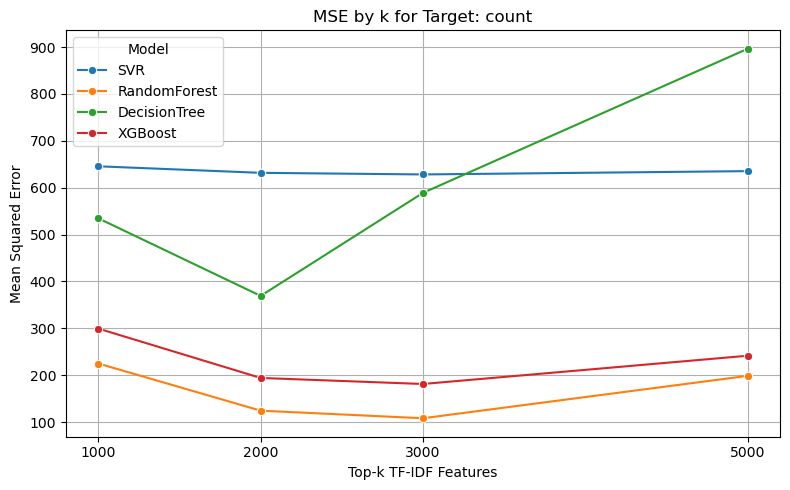

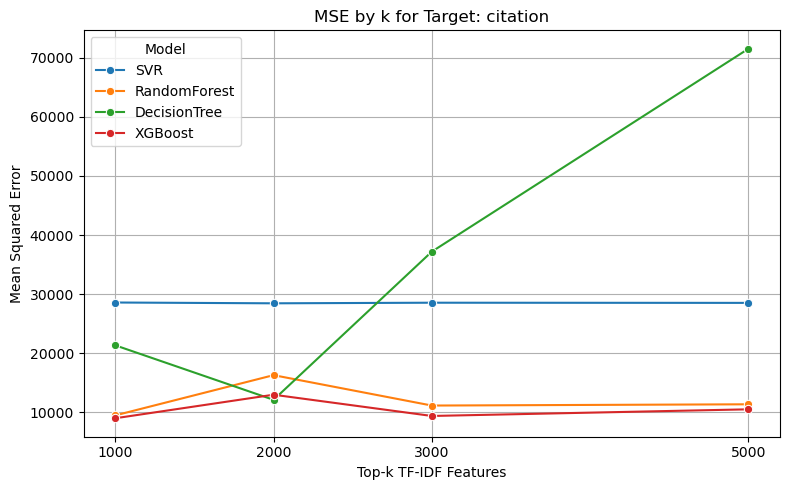

In [8]:
# 分解 target 為 type 與 k
results_df[['type', 'k']] = results_df['target'].str.extract(r'(\w+)_k(\d+)')
results_df['k'] = results_df['k'].astype(int)

# 繪圖：同一 target type 不同 k 值的變化趨勢
for target_type in results_df['type'].unique():
    plt.figure(figsize=(8, 5))
    subset = results_df[results_df['type'] == target_type]
    sns.lineplot(data=subset, x='k', y='MSE', hue='model', marker='o')
    plt.title(f"MSE by k for Target: {target_type}")
    plt.xlabel("Top-k TF-IDF Features")
    plt.ylabel("Mean Squared Error")
    plt.xticks(sorted(results_df['k'].unique()))
    plt.legend(title="Model")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


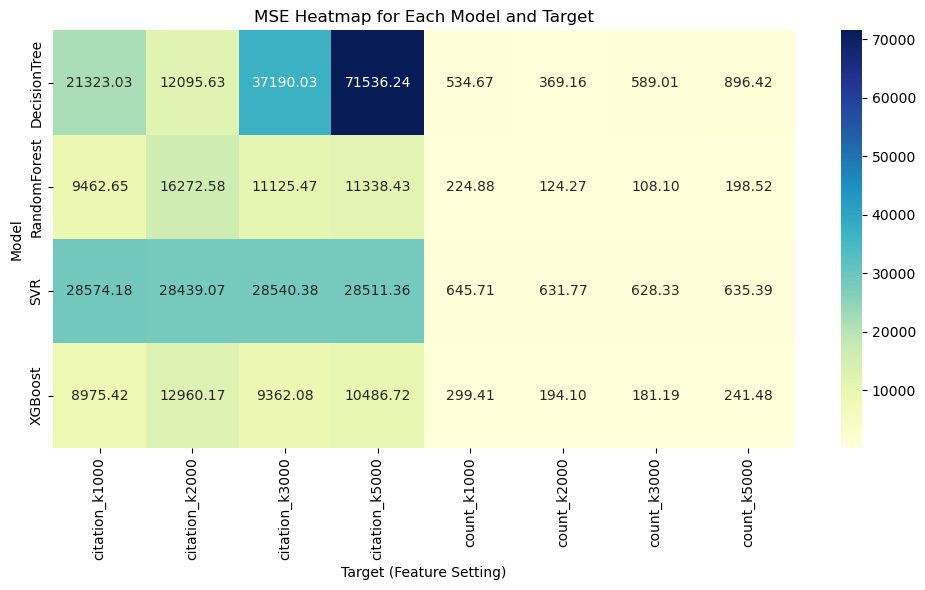

In [9]:
heatmap_data = results_df.pivot_table(index='model', columns='target', values='MSE')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("MSE Heatmap for Each Model and Target")
plt.xlabel("Target (Feature Setting)")
plt.ylabel("Model")
plt.tight_layout()
plt.show()
